In [1]:
import os
import keras
keras.__version__

Using TensorFlow backend.


'2.1.0'

In [2]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [3]:
seed = 1
batch_size= 4

image_datagen = ImageDataGenerator(
#     samplewise_center=True,
#     samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

mask_datagen  = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
     width_shift_range=0.1,
     height_shift_range=0.1,
     horizontal_flip=True)

image_generator = image_datagen.flow_from_directory(
        './train/',
        classes = ['image'],
        target_size=(128, 128),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        class_mode=None)

mask_generator = mask_datagen.flow_from_directory(
    './train/',
    classes = ['label'],
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    seed=seed,                      # 注意必须用seed,否则image和mask不匹配
    class_mode=None)

val_image_generator = image_datagen.flow_from_directory(
        './val/',
        classes = ['image'],
        target_size=(128, 128),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        class_mode=None)

val_mask_generator = mask_datagen.flow_from_directory(
    './val/',
    classes = ['label'],
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    seed=seed,
    class_mode=None)

# test_datagen = ImageDataGenerator(
#     samplewise_center=True,
#     samplewise_std_normalization=True)

# test_image_generator = test_datagen.flow_from_directory(
#         './brain/test/',
#         classes = ['image'],
#         target_size=(128, 128),
#         color_mode="grayscale",
#         batch_size=batch_size,
#         seed=seed,
#         class_mode=None)

train_generator = zip(image_generator, mask_generator)
validation_generator = zip(val_image_generator, val_mask_generator)

Found 60 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 14 images belonging to 1 classes.
Found 14 images belonging to 1 classes.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf

In [6]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [7]:
def unet(sz = (128, 128, 1)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 4):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 3):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [8]:
model = unet()

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
smooth = 1e-5
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [13]:
model.compile(optimizer='adam',
              loss=dice_coef_loss,
              metrics=['accuracy',mean_iou,dice_coef])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=15,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=4)

Epoch 1/30
15/15 [==============================] - 10s 681ms/step - loss: 0.4280 - acc: 0.3616 - mean_iou: 0.3247 - dice_coef: 0.5720 - val_loss: 0.3972 - val_acc: 0.6659 - val_mean_iou: 0.4801 - val_dice_coef: 0.6028
Epoch 2/30
15/15 [==============================] - 1s 88ms/step - loss: 0.3143 - acc: 0.7207 - mean_iou: 0.5365 - dice_coef: 0.6857 - val_loss: 0.2127 - val_acc: 0.9138 - val_mean_iou: 0.7731 - val_dice_coef: 0.7873
Epoch 3/30
15/15 [==============================] - 1s 83ms/step - loss: 0.1085 - acc: 0.9350 - mean_iou: 0.8220 - dice_coef: 0.8915 - val_loss: 0.0388 - val_acc: 0.9729 - val_mean_iou: 0.9138 - val_dice_coef: 0.9612
Epoch 4/30
15/15 [==============================] - 1s 81ms/step - loss: 0.0479 - acc: 0.9654 - mean_iou: 0.8978 - dice_coef: 0.9521 - val_loss: 0.0236 - val_acc: 0.9828 - val_mean_iou: 0.9447 - val_dice_coef: 0.9764
Epoch 5/30
15/15 [==============================] - 1s 80ms/step - loss: 0.0366 - acc: 0.9736 - mean_iou: 0.9196 - dice_coef: 0.96

In [10]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',mean_iou])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=15,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=4)

Epoch 1/50
15/15 [==============================] - 21s 1s/step - loss: 0.5327 - acc: 0.8034 - mean_iou: 0.4291 - val_loss: 0.1697 - val_acc: 0.9408 - val_mean_iou: 0.8381
Epoch 2/50
15/15 [==============================] - 1s 86ms/step - loss: 0.2057 - acc: 0.9202 - mean_iou: 0.8015 - val_loss: 0.1619 - val_acc: 0.9169 - val_mean_iou: 0.7820
Epoch 3/50
15/15 [==============================] - 1s 86ms/step - loss: 0.1953 - acc: 0.9245 - mean_iou: 0.8148 - val_loss: 0.1244 - val_acc: 0.9758 - val_mean_iou: 0.9275
Epoch 4/50
15/15 [==============================] - 1s 81ms/step - loss: 0.1547 - acc: 0.9430 - mean_iou: 0.8471 - val_loss: 0.0664 - val_acc: 0.9779 - val_mean_iou: 0.9326
Epoch 5/50
15/15 [==============================] - 1s 77ms/step - loss: 0.1358 - acc: 0.9503 - mean_iou: 0.8613 - val_loss: 0.0716 - val_acc: 0.9793 - val_mean_iou: 0.9358
Epoch 6/50
15/15 [==============================] - 1s 79ms/step - loss: 0.1429 - acc: 0.9538 - mean_iou: 0.8691 - val_loss: 0.0916 - va

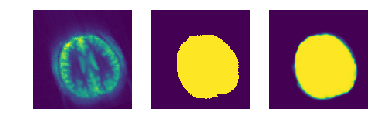

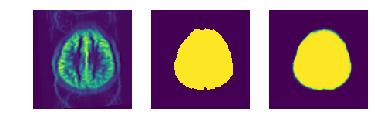

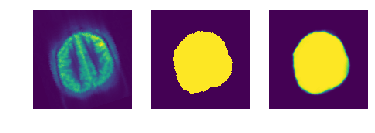

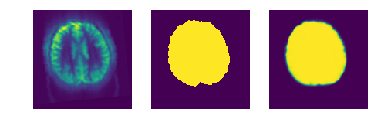

In [17]:
img = val_image_generator.next()
msk = val_mask_generator.next()
pre = model.predict(img)
for i in range(batch_size):
    fig, axes = plt.subplots(1, 3)
    axes[0].set_axis_off()
    axes[0].imshow(img[i].reshape(img[0].shape[:-1]))
    axes[1].set_axis_off()
    axes[1].imshow(msk[i].reshape(img[0].shape[:-1]))
    axes[2].set_axis_off()
    axes[2].imshow(pre[i].reshape(img[0].shape[:-1]))
plt.show()

In [18]:
import matplotlib.pyplot as plt

def loss_plot(history):
    plt.clf()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def accuracy_plot(history):
    plt.clf()
    
    acc_values = history.history['acc']
    val_acc_values = history.history['val_acc']
    epochs = range(1, len(acc_values) + 1)
    
    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
def miou_plot(history):
    plt.clf()
    
    iou_values = history.history['mean_iou']
    val_iou_values = history.history['val_mean_iou']
    epochs = range(1, len(iou_values) + 1)
    
    plt.plot(epochs, iou_values, 'bo', label='Training iou')
    plt.plot(epochs, val_iou_values, 'b', label='Validation iou')
    plt.title('Training and validation mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()

    plt.show()
    
def dice_plot(history):
    plt.clf()
    
    iou_values = history.history['dice_coef']
    val_iou_values = history.history['val_dice_coef']
    epochs = range(1, len(iou_values) + 1)
    
    plt.plot(epochs, iou_values, '-', label='Training dice')
    plt.plot(epochs, val_iou_values, '--', label='Validation dice')
    plt.title('Training and validation dice')
    plt.xlabel('Epochs')
    plt.ylabel('dice')
    plt.legend()

    plt.show()

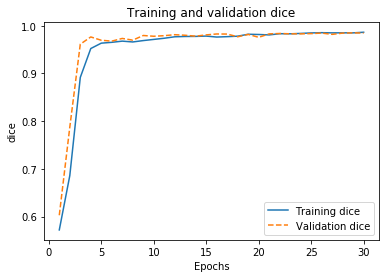

In [19]:
dice_plot(history)

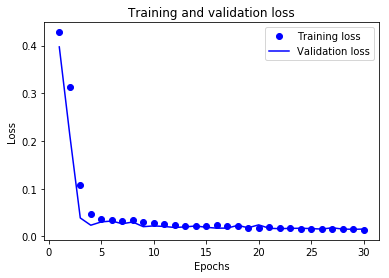

In [20]:
loss_plot(history)

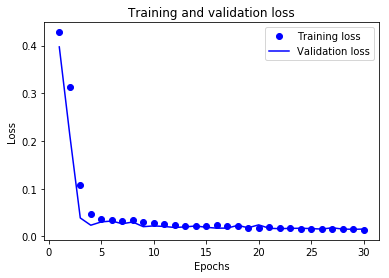

In [21]:
loss_plot(history)

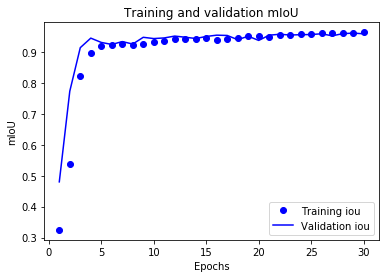

In [22]:
miou_plot(history)

In [22]:
model.save("unet.h5")

In [2]:
import tensorflow as tf

model = 'unet.pb'
graph = tf.get_default_graph()
graph_def = graph.as_graph_def()
graph_def.ParseFromString(tf.gfile.FastGFile(model, 'rb').read())
tf.import_graph_def(graph_def, name='graph')
summaryWriter = tf.summary.FileWriter('log/', graph)